¡A entrenar mi red neuronal!
Iteracion 0 - Perdida: 0.9993, Prec. Train: 0.4688, Prec. Val: 0.4225
Iteracion 1000 - Perdida: 0.3537, Prec. Train: 0.8438, Prec. Val: 0.8137
Iteracion 2000 - Perdida: 0.4053, Prec. Train: 0.8438, Prec. Val: 0.8425
Iteracion 3000 - Perdida: 0.3517, Prec. Train: 0.8438, Prec. Val: 0.8588
Iteracion 4000 - Perdida: 0.2945, Prec. Train: 0.9062, Prec. Val: 0.8700
Iteracion 5000 - Perdida: 0.1844, Prec. Train: 0.9062, Prec. Val: 0.8788
Iteracion 6000 - Perdida: 0.2836, Prec. Train: 0.8125, Prec. Val: 0.8825
Iteracion 7000 - Perdida: 0.3438, Prec. Train: 0.8438, Prec. Val: 0.8888
Iteracion 8000 - Perdida: 0.1405, Prec. Train: 0.9375, Prec. Val: 0.8925
Iteracion 9000 - Perdida: 0.1197, Prec. Train: 0.9688, Prec. Val: 0.8900
Iteracion 10000 - Perdida: 0.2477, Prec. Train: 0.9062, Prec. Val: 0.8962
Iteracion 11000 - Perdida: 0.2291, Prec. Train: 0.9062, Prec. Val: 0.8938
Iteracion 12000 - Perdida: 0.3224, Prec. Train: 0.8438, Prec. Val: 0.8925
Iteracion 13000 - Perd

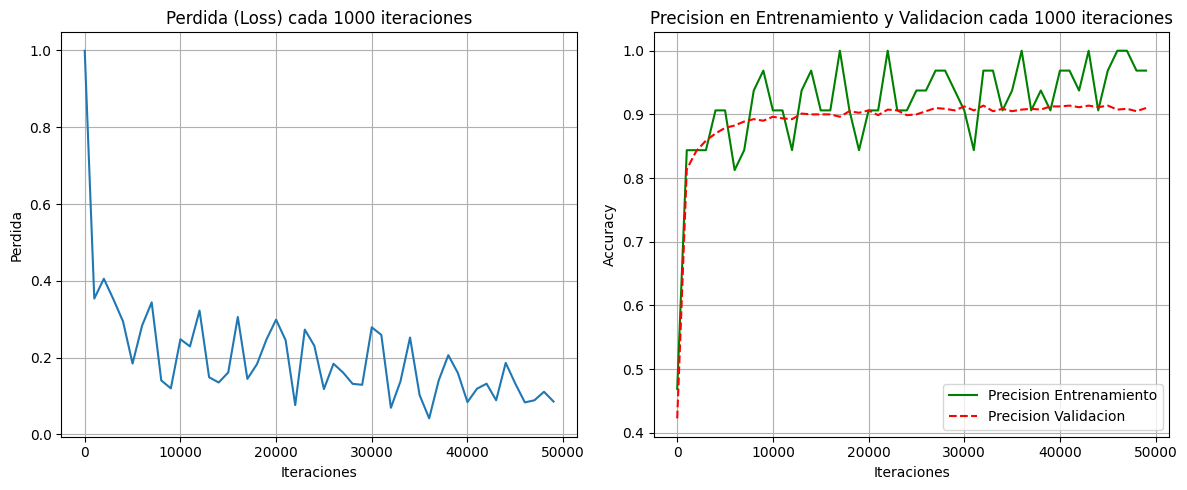


 pruebo una prediccion 
Manzana de CALIDAD BUENA (Probabilidad: 0.6557)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

# --- CARGA Y PREPROCESAMIENTO DE MIS DATOS ---
df_processed = pd.read_csv("apple_actualizado.csv")

X = df_processed[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']].values
y = df_processed['Quality_numeric'].values.reshape(-1, 1)

# Normalizo mis datos para que esten en la misma escala (entre 0 y 1, mas o menos).
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Divido mis datos en dos grupos: uno para entrenar la red y otro para validarla (para ver si aprende bien).
# El 80% es para entrenar (train) y el 20% para validar (val).
# El 'random_state=42' es un numero que elijo para que, cada vez que corra el codigo, la division sea la misma.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_t = X_train.T  
y_train_t = y_train.T  
X_val_t = X_val.T     
y_val_t = y_val.T      

# Aca decido cuantas "neuronas" va a tener cada capa de mi red.
input_dim = X_train_t.shape[0] 
h1_dim = 16 # Mi primera capa oculta tendra 16 neuronas.
h2_dim = 8  # Mi segunda capa oculta tendra 8 neuronas.
output_dim = 1 # Mi capa de salida solo tendra 1 neurona (para predecir si es buena o mala).

# --- MIS FUNCIONES DE ACTIVACION Y SUS DERIVADAS ---
# La funcion Sigmoid: la uso en la ultima capa. Transforma cualquier numero en un valor entre 0 y 1.
def sigmoid(x): return 1 / (1 + np.exp(-x))

# La derivada de Sigmoid: la necesito para el backpropagation
def sigmoid_deriv(x): s = sigmoid(x); return s * (1 - s)

# Si el numero es positivo, lo deja igual; si es negativo o cero, lo convierte en 0.
def relu(x): return np.maximum(0, x)
# la necesito para el backpropagation. Es 1 si el numero es positivo, 0 si no.
def relu_deriv(x): return (x > 0).astype(float)

# --- INICIALIZACION DE PESOS Y SESGOS ---
np.random.seed(0) #es para que, cada vez que ejecute el codigo, mis pesos inicien con los mismos valores aleatorios.

# Pesos y sesgos para la primera capa oculta (conectan la entrada con h1)
W1 = np.random.rand(h1_dim, input_dim) * 2 - 1
b1 = np.random.rand(h1_dim, 1) * 2 - 1

# Pesos y sesgos para la segunda capa oculta (conectan h1 con h2)
W2 = np.random.rand(h2_dim, h1_dim) * 2 - 1
b2 = np.random.rand(h2_dim, 1) * 2 - 1

# Pesos y sesgos para la capa de salida (conectan h2 con la salida final)
W3 = np.random.rand(output_dim, h2_dim) * 2 - 1
b3 = np.random.rand(output_dim, 1) * 2 - 1

def forward_prop(X_input):

    Z1 = W1 @ X_input + b1
    A1 = relu(Z1) # Aplico la funcion de activacion ReLU.

    # Calculo para la segunda capa oculta.
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)

    # Calculo para la capa de salida.
    Z3 = W3 @ A2 + b3
    A3 = sigmoid(Z3) # Para la salida final, uso Sigmoid porque me da una probabilidad entre 0 y 1
    return Z1, A1, Z2, A2, Z3, A3 # Devuelvo todos estos valores, para el backpropagation

iteraciones = 50000 
batch_size = 32 # "mini-batch"
lr = 0.01 

def entrenar_red():
    global W1, b1, W2, b2, W3, b3, lr

    loss_hist, acc_train_hist, acc_val_hist = [], [], []

    num_samples_train = X_train_t.shape[1] # cuantas muestras de entrenamiento tengo en total

    for it in range(iteraciones):
        idx = np.random.choice(num_samples_train, size=batch_size, replace=False)
        Xb = X_train_t[:, idx] 
        yb = y_train_t[:, idx] 

        Z1, A1, Z2, A2, Z3, A3 = forward_prop(Xb)

        # Calculo la "perdida" (loss), que tan mal estoy prediciendo.
        loss = -np.mean(yb * np.log(A3 + 1e-8) + (1 - yb) * np.log(1 - A3 + 1e-8))

        # Calculo la precision 
        # Si A3 es mayor a 0.5, digo que la manzana es buena (1). Si no, es mala (0).
        acc_train = accuracy_score(yb.flatten(), (A3 > 0.5).astype(int).flatten())

        if it % 1000 == 0:
            _, _, _, _, _, val_preds = forward_prop(X_val_t)
            acc_val = accuracy_score(y_val_t.flatten(), (val_preds > 0.5).astype(int).flatten())

            loss_hist.append(loss)
            acc_train_hist.append(acc_train)
            acc_val_hist.append(acc_val)

            print(f"Iteracion {it} - Perdida: {loss:.4f}, Prec. Train: {acc_train:.4f}, Prec. Val: {acc_val:.4f}")

        # BACKPROPAGATION 

        # caluclo el error en la capa de salida (dZ3). 
        dZ3 = A3 - yb
        # Calculo como ajustar los pesos de la ultima capa (dW3).
        # (dZ3 @ A2.T) es la multiplicacion de matrices para obtener el gradiente.
        dW3 = (dZ3 @ A2.T) / batch_size
        # Calculo como ajustar el sesgo de la ultima capa (db3).
        db3 = np.sum(dZ3, axis=1, keepdims=True) / batch_size

        # Backpropagation el error a la capa anterior (h2).
        dA2 = W3.T @ dZ3 
        dZ2 = dA2 * relu_deriv(Z2) 
        dW2 = (dZ2 @ A1.T) / batch_size # Ajuste de pesos
        db2 = np.sum(dZ2, axis=1, keepdims=True) / batch_size # Ajuste de sesgo 

        # Backpropagation el error a la primera capa oculta (h1).
        dA1 = W2.T @ dZ2
        dZ1 = dA1 * relu_deriv(Z1)
        dW1 = (dZ1 @ Xb.T) / batch_size 
        db1 = np.sum(dZ1, axis=1, keepdims=True) / batch_size 

        # actualizo mis variables globales W y b.

        W3 -= lr * dW3
        b3 -= lr * db3
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1
            
    return loss_hist, acc_train_hist, acc_val_hist

# --------------------------------------------
# EJECUTANDO EL ENTRENAMIENTO Y VIENDO LOS RESULTADOS FINALES
# --------------------------------------------
print("entrenando la red")
start = time.time() 
losses, accs_train, accs_val = entrenar_red()
print(f"Mi red tardo: {time.time() - start:.2f} segundos en entrenar.") 

_, _, _, _, _, train_preds = forward_prop(X_train_t)
_, _, _, _, _, val_preds = forward_prop(X_val_t)

# Calculo la precision final
train_acc = accuracy_score(y_train_t.flatten(), (train_preds > 0.5).astype(int).flatten())
val_acc = accuracy_score(y_val_t.flatten(), (val_preds > 0.5).astype(int).flatten())

print("\n Resultados finales ")
print(f"Precision en el set de entrenamiento: {train_acc:.4f}")
print(f"Precision en el set de validacion: {val_acc:.4f}")

# --------------------------------------------
# GRAFICOS 
# --------------------------------------------
plt.figure(figsize=(12, 5)) 

# GRAFICO 1: loss 
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, iteraciones, 1000), losses) 
plt.title("Perdida (Loss) cada 1000 iteraciones") 
plt.xlabel("Iteraciones") 
plt.ylabel("Perdida") 
plt.grid(True) 

# GRAFICO 2: presicion
plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, iteraciones, 1000), accs_train, label='Precision Entrenamiento', color='green')
plt.plot(np.arange(0, iteraciones, 1000), accs_val, label='Precision Validacion', color='red', linestyle='--')
plt.title("Precision en Entrenamiento y Validacion cada 1000 iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Accuracy")
plt.legend() 
plt.grid(True)

plt.tight_layout()
plt.show() 

# --------------------------------------------
# EJEMPLO DE PREDICCION CON UN NUEVO DATO 
# --------------------------------------------
def predict_single_sample(input_data_dict):
    df_single = pd.DataFrame([input_data_dict])
    
    # normalizo
    features_order = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
    X_single = scaler.transform(df_single[features_order].values)
    
    # Transpongo el dato para que tenga la forma (caracteristicas, 1)
    X_single_t = X_single.T
    
    _, _, _, _, _, prediction = forward_prop(X_single_t)
    
    return prediction[0, 0]

def predecir_si_buena_manzana(input_data_dict):
    prob_buena = predict_single_sample(input_data_dict)
    if prob_buena > 0.5:
        return f"Manzana de CALIDAD BUENA (Probabilidad: {prob_buena:.4f})"
    else:
        return f"Manzana de CALIDAD MALA (Probabilidad: {prob_buena:.4f})"

# ej d prueba
print("\n pruebo una prediccion ")
datos_ejemplo = {
    'Size': 0.7, 'Weight': 0.6, 'Sweetness': 0.8, 'Crunchiness': 0.7,
    'Juiciness': 0.8, 'Ripeness': 0.9, 'Acidity': 0.2
}

resultado_prediccion = predecir_si_buena_manzana(datos_ejemplo)
print(resultado_prediccion)

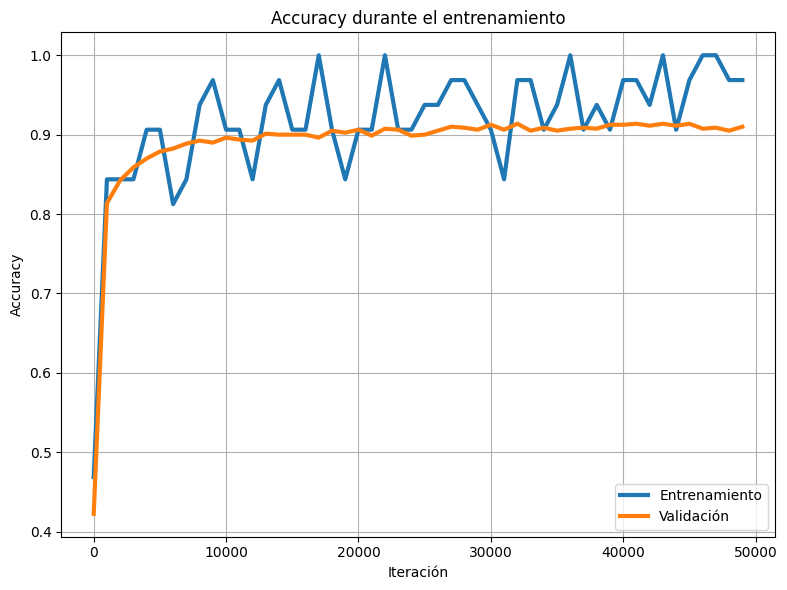

In [13]:
fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
fmt_val = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}

steps = np.arange(0, 50000, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(steps, accs_train, label='Entrenamiento', **fmt_train)
ax.plot(steps, accs_val, label='Validación', **fmt_val)

ax.grid(True)
ax.legend()
ax.set_title('Accuracy durante el entrenamiento')
ax.set_xlabel('Iteración')
ax.set_ylabel('Accuracy')
fig.tight_layout()
plt.show()


In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

mlp = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='sgd',
                    learning_rate_init=0.01, max_iter=50000, random_state=42, verbose=False)

print("Entrenando red neuronal con scikit-learn...")
start_skl = time.time()
mlp.fit(X_train, y_train.ravel()) # .ravel() para convertir y_train a un array 1D
end_skl = time.time()
print(f"Tiempo total de entrenamiento con scikit-learn: {end_skl - start_skl:.2f} segundos")

# Predecir y evaluar
y_train_pred_skl = mlp.predict(X_train)
y_val_pred_skl = mlp.predict(X_val)

train_acc_skl = accuracy_score(y_train, y_train_pred_skl)
val_acc_skl = accuracy_score(y_val, y_val_pred_skl)

print("\n--- Resultados scikit-learn ---")
print(f"Precision en entrenamiento (scikit-learn): {train_acc_skl:.4f}")
print(f"Precision en validación (scikit-learn): {val_acc_skl:.4f}")

Entrenando red neuronal con scikit-learn...
Tiempo total de entrenamiento con scikit-learn: 4.53 segundos

--- Resultados scikit-learn ---
Precision en entrenamiento (scikit-learn): 0.9478
Precision en validación (scikit-learn): 0.9325
